# Energy Consumption Prediction

## Problem Statement

Konsumsi energi pada bangunan sulit diprediksi secara akurat karena dipengaruhi oleh banyak faktor, seperti cuaca, waktu, dan kebiasaan penggunaan. Tidak adanya sistem prediktif menyebabkan operator bangunan kesulitan dalam mengelola beban puncak, yang berdampak pada efisiensi dan biaya operasional.

## Data Exploration & Preparation



### Import Libraries

In [1]:
!pip install xgboost

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

Dataset yang digunakan dalam proyek ini berjudul **"Energy Consumption Prediction"**, yang diambil dari platform Kaggle:
https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction/data

Fitur:
- Temperature
- Humidity
- Square Footage
- Occupancy
- HVAC (Heating, Ventilation, and Air Conditioning) Usage
- Lighting Usage
- Renewable Energy
- Day Of Week
- Holiday
- Energy Consumption

In [3]:
df = pd.read_csv('energy_consumption.csv')
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


#### Number of rows and columns

In [4]:
# Mengecek jumlah baris dan kolom
print(df.shape)

(1000, 11)


#### Data type of each column

In [5]:
# Mengecek tipe data tiap kolom
print(df.dtypes)

Timestamp             object
Temperature          float64
Humidity             float64
SquareFootage        float64
Occupancy              int64
HVACUsage             object
LightingUsage         object
RenewableEnergy      float64
DayOfWeek             object
Holiday               object
EnergyConsumption    float64
dtype: object


#### Checking for missing values

In [6]:
# Mengecek nilai yang hilang
print(df.isnull().sum())

Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


#### Initial descriptive statistics

In [7]:
# Mengecek statistik deskriptif awal
df.describe()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


### Feature Distribution

Distribusi fitur numerik divisualisasikan menggunakan histogram untuk mengetahui pola penyebaran data.   Langkah ini bertujuan untuk mengidentifikasi apakah data berdistribusi normal, miring (skewed), atau memiliki nilai ekstrem.


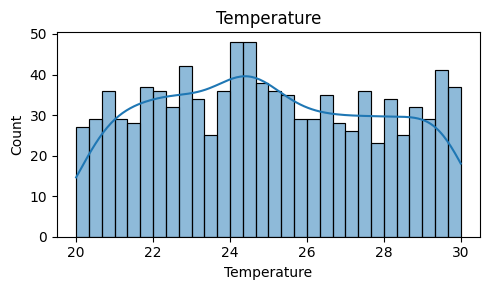

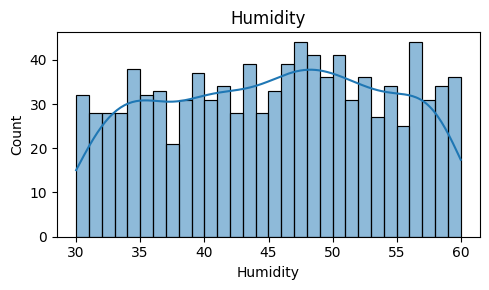

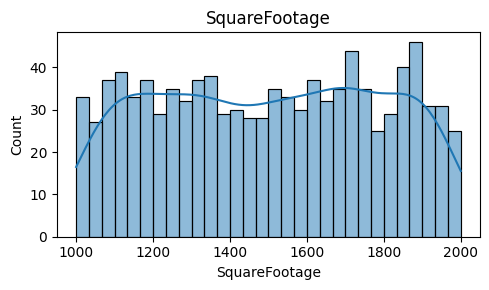

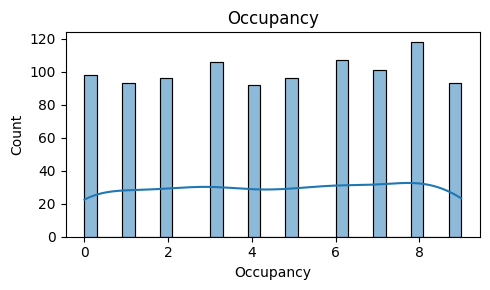

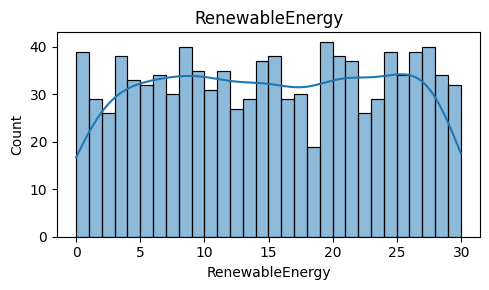

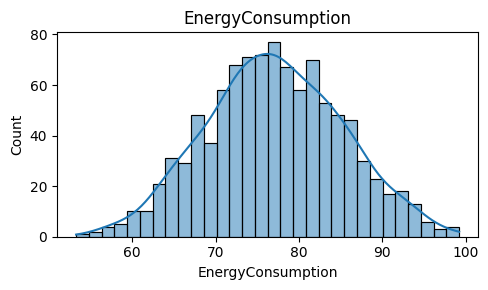

In [8]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualisasi distribusi fitur
for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f'{col}')
    plt.tight_layout()
    plt.show()

### Feature Correlation Heatmap

Korelasi antar fitur numerik dianalisis menggunakan heatmap. Langkah ini bertujuan untuk memahami hubungan antar variabel dan mendeteksi fitur yang mungkin saling berkaitan kuat.


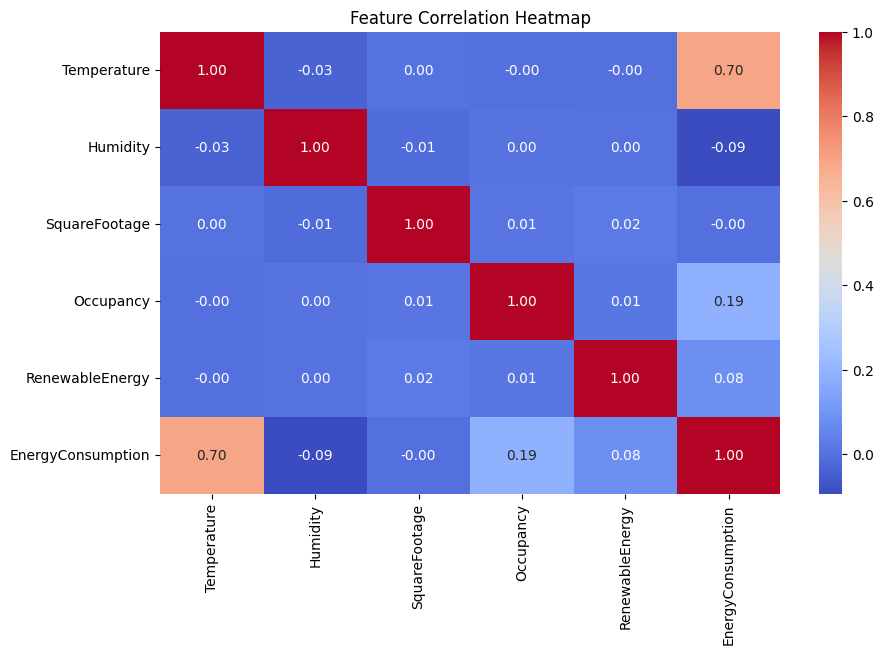

In [9]:
# Visualisasi heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Outlier Detection

Outlier atau nilai ekstrem dideteksi menggunakan metode IQR (Interquartile Range). Langkah ini bertujuan untuk mengetahui apakah terdapat data yang menyimpang jauh dari mayoritas nilai lainnya.

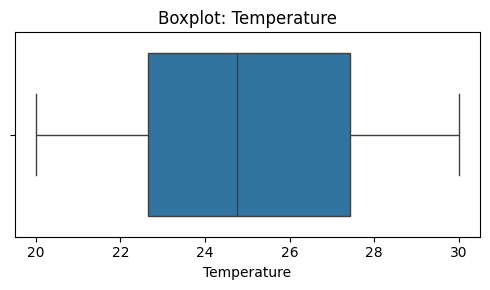

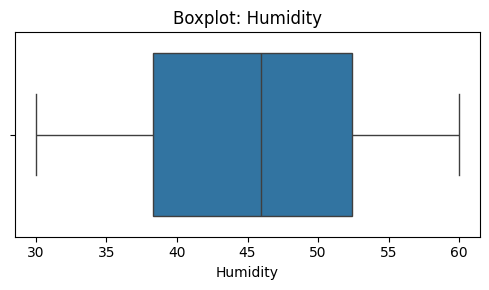

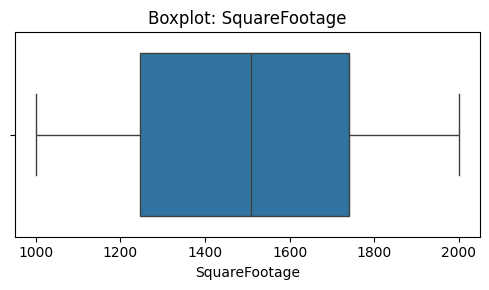

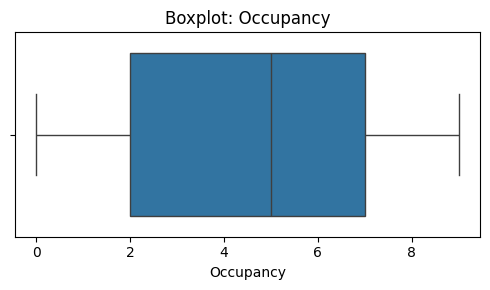

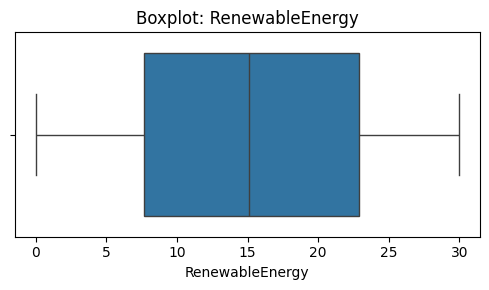

In [10]:
# Ambil fitur numerik
num_cols = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy']

# Simpan hasil outlier
outlier_report = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_report[col] = len(outliers)

# Visualisasi boxplot
for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

### Preprocessing

#### Feature Selection

Pada tahap ini, dilakukan pemisahan antara variabel input (fitur/X) dan variabel yang ingin diprediksi (target/y). Fitur terdiri dari variabel-variabel yang diasumsikan memiliki pengaruh terhadap target. Sementara itu, target adalah variabel yang akan diprediksi oleh model, yaitu EnergyConsumption.

In [11]:
# Memisahkan fitur dan target
features = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
    'HVACUsage', 'LightingUsage', 'RenewableEnergy',
    'DayOfWeek', 'Holiday'
]

X = df[features]
y = df['EnergyConsumption']

#### Categorical Data Encoding & Numerical Data Scaling

Fitur numerik dilakukan standardisasi agar berada dalam skala yang sama. Sementara itu, fitur kategorikal diubah menggunakan one-hot encoding. Hal ini dilakukan agar fitur tersebut dapat diproses oleh algoritma machine learning.


In [12]:
# Mendeteksi kolom numerikal dan kategorikal
num_cols = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy']
cat_cols = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']

In [13]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

#### Data Splitting

Data dibagi menjadi dua bagian: data latih (training) dan data uji (testing) dengan rasio 80:20. Pembagian ini bertujuan untuk mengevaluasi performa model secara adil terhadap data yang belum pernah dilihat sebelumnya.


In [14]:
# Membagi data ke dalam data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

Beberapa algoritma yang digunakan dalam proyek ini, yaitu:

- **Ridge Regression**: regresi linear dengan regularisasi L2.
- **Lasso Regression**: regresi linear dengan regularisasi L1.
- **Random Forest Regressor**: algoritma ensambel berbasis Decision Tree yang cukup kuat terhadap outlier.
- **XGBoost Regressor**: algoritma Boosting yang sering digunakan karena akurasinya yang tinggi dan efisiensinya.


In [15]:
# Model pipeline (default)
baseline_models = {
    "Ridge Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", Ridge())
    ]),
    "Lasso Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", Lasso())
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(eval_metric="rmse", random_state=42))
    ])
}

#### Hyperparameter Tuning

Tuning dilakukan untuk mengoptimalkan parameter secara efisien dan menghindari overfitting. Seluruh model dituning menggunakan RandomizedSearchCV untuk meningkatkan performa prediksi dan dibandingkan dengan hasil baseline.


In [16]:
# Dictionary model hasil tuning
tuned_models = {}

# 1. Ridge Regression (tuning alpha = regularisasi)
ridge = Ridge()
param_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
rs_ridge = RandomizedSearchCV(ridge, param_ridge, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, random_state=42)
rs_ridge.fit(preprocessor.fit_transform(X), y)
tuned_models["Ridge Regression"] = Pipeline([("preprocess", preprocessor), ("model", rs_ridge.best_estimator_)])

# 2. Lasso Regression
lasso = Lasso()
param_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}
rs_lasso = RandomizedSearchCV(lasso, param_lasso, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, random_state=42)
rs_lasso.fit(preprocessor.fit_transform(X), y)
tuned_models["Lasso Regression"] = Pipeline([("preprocess", preprocessor), ("model", rs_lasso.best_estimator_)])

# 3. Random Forest
rf = RandomForestRegressor(random_state=42)
param_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10]
}
rs_rf = RandomizedSearchCV(rf, param_rf, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, random_state=42)
rs_rf.fit(preprocessor.fit_transform(X), y)
tuned_models["Random Forest"] = Pipeline([("preprocess", preprocessor), ("model", rs_rf.best_estimator_)])

# 4. XGBoost
xgb = XGBRegressor(eval_metric='rmse', random_state=42)
param_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}
rs_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, random_state=42)
rs_xgb.fit(preprocessor.fit_transform(X), y)
tuned_models["XGBoost"] = Pipeline([("preprocess", preprocessor), ("model", rs_xgb.best_estimator_)])


In [17]:
# Parameter terbaik dari RandomizedSearchCV
print("Ridge Regression:", rs_ridge.best_params_)
print("Lasso Regression:", rs_lasso.best_params_)
print("Random Forest   :", rs_rf.best_params_)
print("XGBoost         :", rs_xgb.best_params_)

Ridge Regression: {'alpha': 10}
Lasso Regression: {'alpha': 0.01}
Random Forest   : {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 8}
XGBoost         : {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


## Model Evaluation

Evaluasi dilakukan menggunakan tiga metrik regresi utama, yaitu:

- **MAE (Mean Absolute Error)**: rata-rata selisih absolut antara nilai prediksi dan nilai asli.
- **RMSE (Root Mean Squared Error)**: mengukur besarnya error dengan penalti lebih besar untuk kesalahan besar.
- **R-squared Score**: proporsi variansi dalam target yang dapat dijelaskan oleh model.

Ketiga metrik ini digunakan untuk menilai sejauh mana prediksi model mendekati nilai asli.


#### Model with Default Parameter

In [18]:
# Evaluasi hasil baseline
baseline_results = []

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    baseline_results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred),
        "R-squared": r2_score(y_test, y_pred)
    })

# DataFrame hasil baseline
baseline_df = pd.DataFrame(baseline_results).sort_values(by="RMSE")
baseline_df

,Model,MAE,RMSE,R-squared
0,Ridge Regression,4.120552,26.545813,0.594720
2,Random Forest,4.406813,29.947678,0.542783
3,XGBoost,4.598994,33.429241,0.489629
1,Lasso Regression,4.586567,33.838268,0.483384


#### Model with Tuned Parameter

In [19]:
# Evaluasi hasil tuning model

tuning_results = []

for name, pipe in tuned_models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    tuning_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R-squared": r2
    })

# Buat DataFrame
results_df = pd.DataFrame(tuning_results).sort_values(by="RMSE")
results_df

,Model,MAE,RMSE,R-squared
1,Lasso Regression,4.117428,26.436252,0.596392
0,Ridge Regression,4.122980,26.545545,0.594724
2,Random Forest,4.329295,29.408117,0.551020
3,XGBoost,4.350972,29.873424,0.543916


#### Comparison of Baseline and Tuned Models

In [20]:
baseline_df['Status'] = 'Baseline'
results_df['Status'] = 'Tuned'

compare_df = pd.concat([baseline_df, results_df], ignore_index=True)

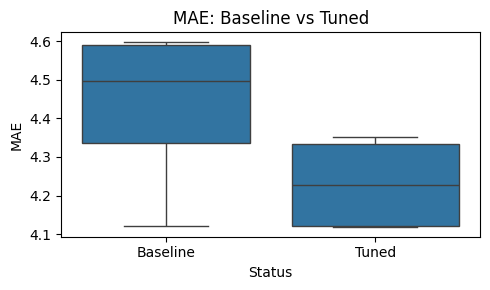

In [27]:
# MAE
plt.figure(figsize=(5, 3))
sns.boxplot(x='Status', y='MAE', data=compare_df)
plt.title('MAE: Baseline vs Tuned')
plt.tight_layout()
plt.show()

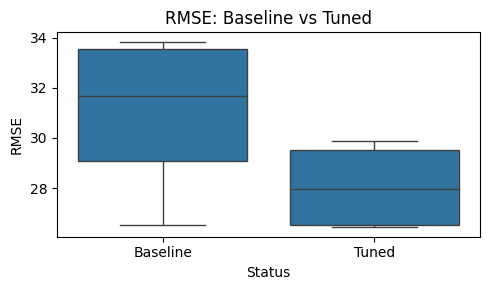

In [28]:
# RMSE
plt.figure(figsize=(5, 3))
sns.boxplot(x='Status', y='RMSE', data=compare_df)
plt.title('RMSE: Baseline vs Tuned')
plt.tight_layout()
plt.show()

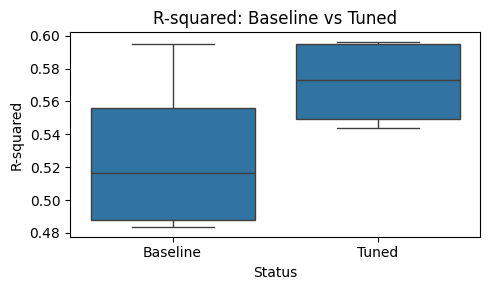

In [29]:
# R-squared Score
plt.figure(figsize=(5, 3))
sns.boxplot(x='Status', y='R-squared', data=compare_df)
plt.title('R-squared: Baseline vs Tuned')
plt.tight_layout()
plt.show()

## Conclusion

Berdasarkan hasil evaluasi terhadap empat model regresi (Ridge, Lasso, Random Forest, dan XGBoost), tuning parameter menggunakan RandomizedSearchCV memberikan peningkatan performa secara umum dibandingkan model dengan parameter default (baseline).

- **Lasso Regression** menunjukkan peningkatan signifikan, dari RMSE 33.84 (baseline) menjadi 26.44 (tuned), dan R-squared meningkat dari 0.48 menjadi 0.60.
- **XGBoost dan Random Forest** juga mengalami penurunan nilai RMSE dan kenaikan R-squared, walaupun peningkatannya relatif kecil.
- **Ridge Regression** memiliki performa yang relatif stabil, dengan hasil tuning yang hampir sama dengan baseline.

Secara keseluruhan, tuning berhasil meningkatkan kinerja model, terutama pada model linear seperti Lasso, yang sebelumnya menunjukkan performa terburuk namun menjadi model terbaik setelah tuning. Dengan demikian, Proses tuning hyperparameter terbukti bermanfaat dalam meningkatkan akurasi prediksi model regresi untuk kasus ini.